## Evaluation

[Evaluation of RAG pipelines with Ragas ](https://langfuse.com/guides/cookbook/evaluation_of_rag_with_ragas)

[Run Langchain Evaluations on data in Langfuse](https://langfuse.com/guides/cookbook/evaluation_with_langchain)

[Evaluate Langfuse LLM Traces with UpTrain](https://langfuse.com/guides/cookbook/evaluation_with_uptrain)
 
[Evaluate Langfuse LLM Traces with an External Evaluation Pipeline](https://langfuse.com/guides/cookbook/example_external_evaluation_pipelines)

[Synthetic Dataset Generation for LLM Evaluation](https://langfuse.com/guides/cookbook/example_synthetic_datasets)

### [Evaluation of RAG pipelines with Ragas ](https://langfuse.com/guides/cookbook/evaluation_of_rag_with_ragas)

Langfuse offers the feature to score your traces and spans. They can be used in multiple ways across Langfuse:

1. Displayed on trace to provide a quick overview
2. Segment all execution traces by scores to e.g. find all traces with a low-quality score
3. Analytics: Detailed score reporting with drill downs into use cases and user segments

Ragas is an open-source tool that can help you run Model-Based Evaluation on your traces/spans, especially for RAG pipelines. 
Ragas can perform reference-free evaluations of various aspects of your RAG pipeline. 
Because it is reference-free you don’t need ground-truths when running the evaluations and can run it on production traces that you’ve collected with Langfuse.

#### The Environment

In [1]:
import os
 
# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-b26f6b38-1d21-4efb-b0ed-5057200b2148" 
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-842c4b9d-4e56-4325-9df5-5a09408f42b1" 

LANGFUSE_HOST="http://localhost:3000"

# Your openai key
# https://api.siliconflow.cn
# os.environ["OPENAI_API_KEY"] = "sk-nfyvlkiykssllzekmddumkfxggollxgwiteckpcqaxchtgty"
os.environ["OPENAI_API_KEY"] = "73c80b33ad68446ea3f059efe5c1a65f.T2PZjYiHcT2JYx2a"
os.environ["OPENAI_BASE_URL"] = "https://open.bigmodel.cn/api/paas/v4"


In [2]:
from langfuse import get_client

langfuse = get_client()

# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


In [ ]:
%pip install langfuse datasets ragas llama_index python-dotenv openai faiss-cpu --upgrade

In [ ]:
# RLHF的场景构建

from langfuse import observe, get_client
from langfuse.openai import OpenAI

client = OpenAI()

langfuse = get_client()
 
prompt_template = """
You're an expert science communicator, able to explain complex topics in an
approachable manner. Your task is to respond to the questions of users in an
engaging, informative, and friendly way. Stay factual, and refrain from using
jargon. 

Question: {question}
"""
 
# 使用装饰器创建
@observe()
def llm_call(topic):
    langfuse.update_current_trace(
        name=f"Explanation '{topic}'",
        user_id="user_1",
        session_id="session_1",
        metadata={"feature": "RLHF", "version": "v1.0"},
        tags=["llm", "ext_eval"],
    )
    prompt = prompt_template.format(question=topic)
 
    return client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="GLM-4.5-Flash",
 
        temperature=0.6
    ).choices[0].message.content
 
 
topic = "Artificial Intelligence and Machine Learning: How AI is transforming various industries."
print(f"Input: Please explain to me {topic.lower()}")
print(f"Answer: {llm_call(topic)} \n")

Input: Please explain to me artificial intelligence and machine learning: how ai is transforming various industries.
Answer: That's a fantastic question! Artificial Intelligence (AI) and Machine Learning (ML) – think of them as super-smart tools that learn from experience – are quietly revolutionizing how we live and work across almost every industry. They're not just science fiction anymore; they're practical tools making things smarter, faster, and more efficient. Here’s a look at how they're transforming key areas:

1.  **Healthcare: Finding Hidden Patterns & Saving Lives**
    *   **What AI Does:** AI systems can analyze vast amounts of medical data – like X-rays, MRIs, CT scans, and genetic information – much faster and sometimes more accurately than humans. They can spot subtle patterns that might indicate disease early.
    *   **The Impact:** Doctors get powerful assistants that help detect diseases like cancer earlier, leading to better outcomes. AI helps personalize treatment

In [6]:
# 获取 Trace ID
trace_id = "5ab8750c03cdfbf5ddd4b7b1d6d927c9"

# 添加评分
langfuse.create_score(
    name="user_rating",
    value=0.9,
    trace_id=trace_id,
    data_type="NUMERIC",
    comment="用户认为回答准确"
)

#### The Data

For this example, we are going to use a dataset that has already been prepared by querying a RAG system and gathering its outputs. See below for instruction on how to fetch your production data from Langfuse.

The dataset contains the following columns

* question: list[str] - These are the questions your RAG pipeline will be evaluated on.

* answer: list[str] - The answer generated from the RAG pipeline and given to the user.

* contexts: list[list[str]] - The contexts which were passed into the LLM to answer the question.

* ground_truths: list[list[str]] - The ground truth answer to the questions. However, this can be ignored for online evaluations since we will not have access to ground-truth data in our case.


In [3]:
# Hugging Face datasets cache settings

os.environ["STREAMING"] = "true"
os.environ["HF_HOME"] = "E:/data/huggingface"
os.environ["HF_DATASETS_CACHE"] = "E:/data/huggingface/datasets"
os.environ["HF_DATASETS_IN_MEMORY_MAX_SIZE"] = "1000000000"

cache_path = os.environ.get("HF_DATASETS_CACHE", None)
print(f"当前缓存路径: {cache_path}")

当前缓存路径: E:/data/huggingface/datasets


In [ ]:
# Hugging Face datasets 新版本（>= 3.0）已经彻底移除了 dataset script (.py 脚本) 自动下载执行的功能。
# explodinggradients/fiqa 这个数据集是老版本格式，里面有一个 fiqa.py 脚本，之前会被 datasets 自动运行，现在会直接报错。
%pip install datasets==2.14.7

In [5]:
from datasets import load_dataset

try:
    # 尝试加载 explodinggradients/fiqa 数据集
    fiqa_eval = load_dataset("explodinggradients/fiqa", "ragas_eval")['baseline']
    
    print("数据集加载成功!")
    print(fiqa_eval)
except Exception as e:
    print(f"加载数据集失败: {e}")

Using the latest cached version of the dataset since explodinggradients/fiqa couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'ragas_eval' at E:\data\huggingface\datasets\explodinggradients___fiqa\ragas_eval\1.0.0\3dc7b639f5b4b16509a3299a2ceb78bf5fe98ee6b5fee25e7d5e4d290c88efb8 (last modified on Fri Aug  8 11:08:50 2025).


数据集加载成功!
Dataset({
    features: ['question', 'ground_truths', 'answer', 'contexts'],
    num_rows: 30
})


#### The Metrics


For going to measure the following aspects of a RAG system. These metric are from the Ragas library:

1. faithfulness: This measures the factual consistency of the generated answer against the given context.
2. answer_relevancy: Answer Relevancy, focuses on assessing how pertinent the generated answer is to the given prompt.
3. context precision: Context Precision is a metric that evaluates whether all of the ground-truth relevant items present in the contexts are ranked high. Ideally all the relevant chunks must appear at the top ranks. This metric is computed using the question and the contexts, with values ranging between 0 and 1, where higher scores indicate better precision.

Checkout the [RAGAS documentation](https://docs.ragas.io/en/latest/concepts/metrics/index.html) to know more about these metrics and how they work.

In [7]:
# import metrics
from ragas.metrics import (
    Faithfulness,
    ResponseRelevancy,
    LLMContextPrecisionWithoutReference,
)
 
# metrics you chose
metrics = [
    Faithfulness(),
    ResponseRelevancy(),
    LLMContextPrecisionWithoutReference(),
]

Now you have to initialize the metrics with LLMs and Embeddings of your choice. In this example we are going to use OpenAI.

In [8]:
from ragas.run_config import RunConfig
from ragas.metrics.base import MetricWithLLM, MetricWithEmbeddings

# util function to init Ragas Metrics
def init_ragas_metrics(metrics, llm, embeddings):
    for metric in metrics:
        if isinstance(metric, MetricWithLLM):
            metric.llm = llm
        if isinstance(metric, MetricWithEmbeddings):
            metric.embeddings = embeddings
        run_config = RunConfig()
        metric.init(run_config)

In [9]:
from langchain_openai.chat_models import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings

# wrappers
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper

llm = ChatOpenAI(
    api_key="sk-nfyvlkiykssllzekmddumkfxggollxgwiteckpcqaxchtgty",
    base_url="https://api.siliconflow.cn",
    # model="Qwen/Qwen3-8B"
    # model="BAAI/bge-m3"
    # model="deepseek-ai/DeepSeek-V3"
    model="THUDM/GLM-4-9B-0414",
)

emb = OpenAIEmbeddings(
    model="embedding-3"
)

vector = emb.embed_query("who am I?")

print("vector:", vector[:3])
print("length:", len(vector))



init_ragas_metrics(
    metrics, llm=LangchainLLMWrapper(llm), embeddings=LangchainEmbeddingsWrapper(emb)
)

RateLimitError: Error code: 429 - {'error': {'code': '1113', 'message': '余额不足或无可用资源包,请充值。'}}

In [56]:
print(metrics)

[Faithfulness(_required_columns={<MetricType.SINGLE_TURN: 'single_turn'>: {'retrieved_contexts', 'user_input', 'response'}}, name='faithfulness', llm=LangchainLLMWrapper(langchain_llm=ChatOpenAI(...)), output_type=<MetricOutputType.CONTINUOUS: 'continuous'>, nli_statements_prompt=NLIStatementPrompt(instruction=Your task is to judge the faithfulness of a series of statements based on a given context. For each statement you must return verdict as 1 if the statement can be directly inferred based on the context or 0 if the statement can not be directly inferred based on the context., examples=[(NLIStatementInput(context='John is a student at XYZ University. He is pursuing a degree in Computer Science. He is enrolled in several courses this semester, including Data Structures, Algorithms, and Database Management. John is a diligent student and spends a significant amount of time studying and completing assignments. He often stays late in the library to work on his projects.', statements=['

#### The Setup

You can use model-based evaluation with Ragas in 2 ways

1. **Score each Trace**: This means you will run the evaluations for each trace item. This gives you much better idea since of how each call to your RAG pipelines is performing but can be expensive
2. **Score as Batch**: In this method we will take a random sample of traces on a periodic basis and score them. This brings down cost and gives you a rough estimate the performance of your app but can miss out on important samples.
In this cookbook, we’ll show you how to setup both.

#### Score with Trace
Lets take a small example of a single trace and see how you can score that with Ragas. First lets load the data

In [40]:
row = fiqa_eval[0]
row['question'], row['answer']

('How to deposit a cheque issued to an associate in my business into my business account?',
 '\nThe best way to deposit a cheque issued to an associate in your business into your business account is to open a business account with the bank. You will need a state-issued "dba" certificate from the county clerk\'s office as well as an Employer ID Number (EIN) issued by the IRS. Once you have opened the business account, you can have the associate sign the back of the cheque and deposit it into the business account.')

Now lets init a Langfuse client SDK to instrument you app.

In [51]:
from langfuse import get_client
 
langfuse = get_client()

In [30]:
# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


Here we are defining a utility function to score your trace with the metrics you chose.

In [64]:
from ragas.dataset_schema import SingleTurnSample

async def score_with_ragas(query, chunks, answer):
    scores = {}
    for m in metrics:
        sample = SingleTurnSample(
            user_input=query,
            retrieved_contexts=chunks,
            response=answer,
        )
        print(f"calculating {m.name}")
        scores[m.name] = await m.single_turn_ascore(sample)
    return scores

You compute the score with each request. Below I’ve outlined a dummy application that does the following steps

1. gets a question from the user
2. fetch context from the database or vector store that can be used to answer the question from the user
3. pass the question and the contexts to the LLM to generate the answer

All these step are logged as spans in a single trace in langfuse. You can read more about traces and spans from the [langfuse documentation](https://langfuse.com/docs/observability/overview).

In [73]:
# start a new trace when you get a question
question = row['question']
contexts = row['contexts']
answer = row['answer']

with langfuse.start_as_current_span(name="Rag with Ragas(no retrieval) with doris") as trace:
    # Store trace_id for later use
    trace_id = trace.trace_id
    
    # retrieve the relevant chunks
    # chunks = get_similar_chunks(question)
    
    # pass it as span
    with trace.start_as_current_span(
        name="retrieval", 
        input={'question': question}, 
        output={'contexts': contexts}
    ):
        trace.update(input={"question": question, "contexts": contexts})

    # use llm to generate a answer with the chunks
    # answer = get_response_from_llm(question, chunks)
    
    with trace.start_as_current_span(
        name="generation", 
        input={'question': question, 'contexts': contexts}, 
        output={'answer': answer}
    ):
        trace.update(output={"answer": answer})
 
    # compute scores for the question, context, answer tuple
    ragas_scores = await score_with_ragas(question, contexts, answer)
 
print("RAGAS Scores:", ragas_scores)
ragas_scores

calculating faithfulness
calculating answer_relevancy
calculating llm_context_precision_without_reference
RAGAS Scores: {'faithfulness': 1.0, 'answer_relevancy': np.float64(0.9252614612750896), 'llm_context_precision_without_reference': 0.9999999999}


{'faithfulness': 1.0,
 'answer_relevancy': np.float64(0.9252614612750896),
 'llm_context_precision_without_reference': 0.9999999999}

Once the scores are computed you can add them to the trace in Langfuse:

In [ ]:
# send the scores
# Use the trace_id stored from the previous cell
for m in metrics:
    langfuse.create_score(
        name=m.name, 
        value=ragas_scores[m.name], 
        trace_id=trace_id
    )

[trace url](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces?peek=f0bba2950dca10c0e9232cfe899fa968&timestamp=2025-08-08T08%3A00%3A19.889Z)

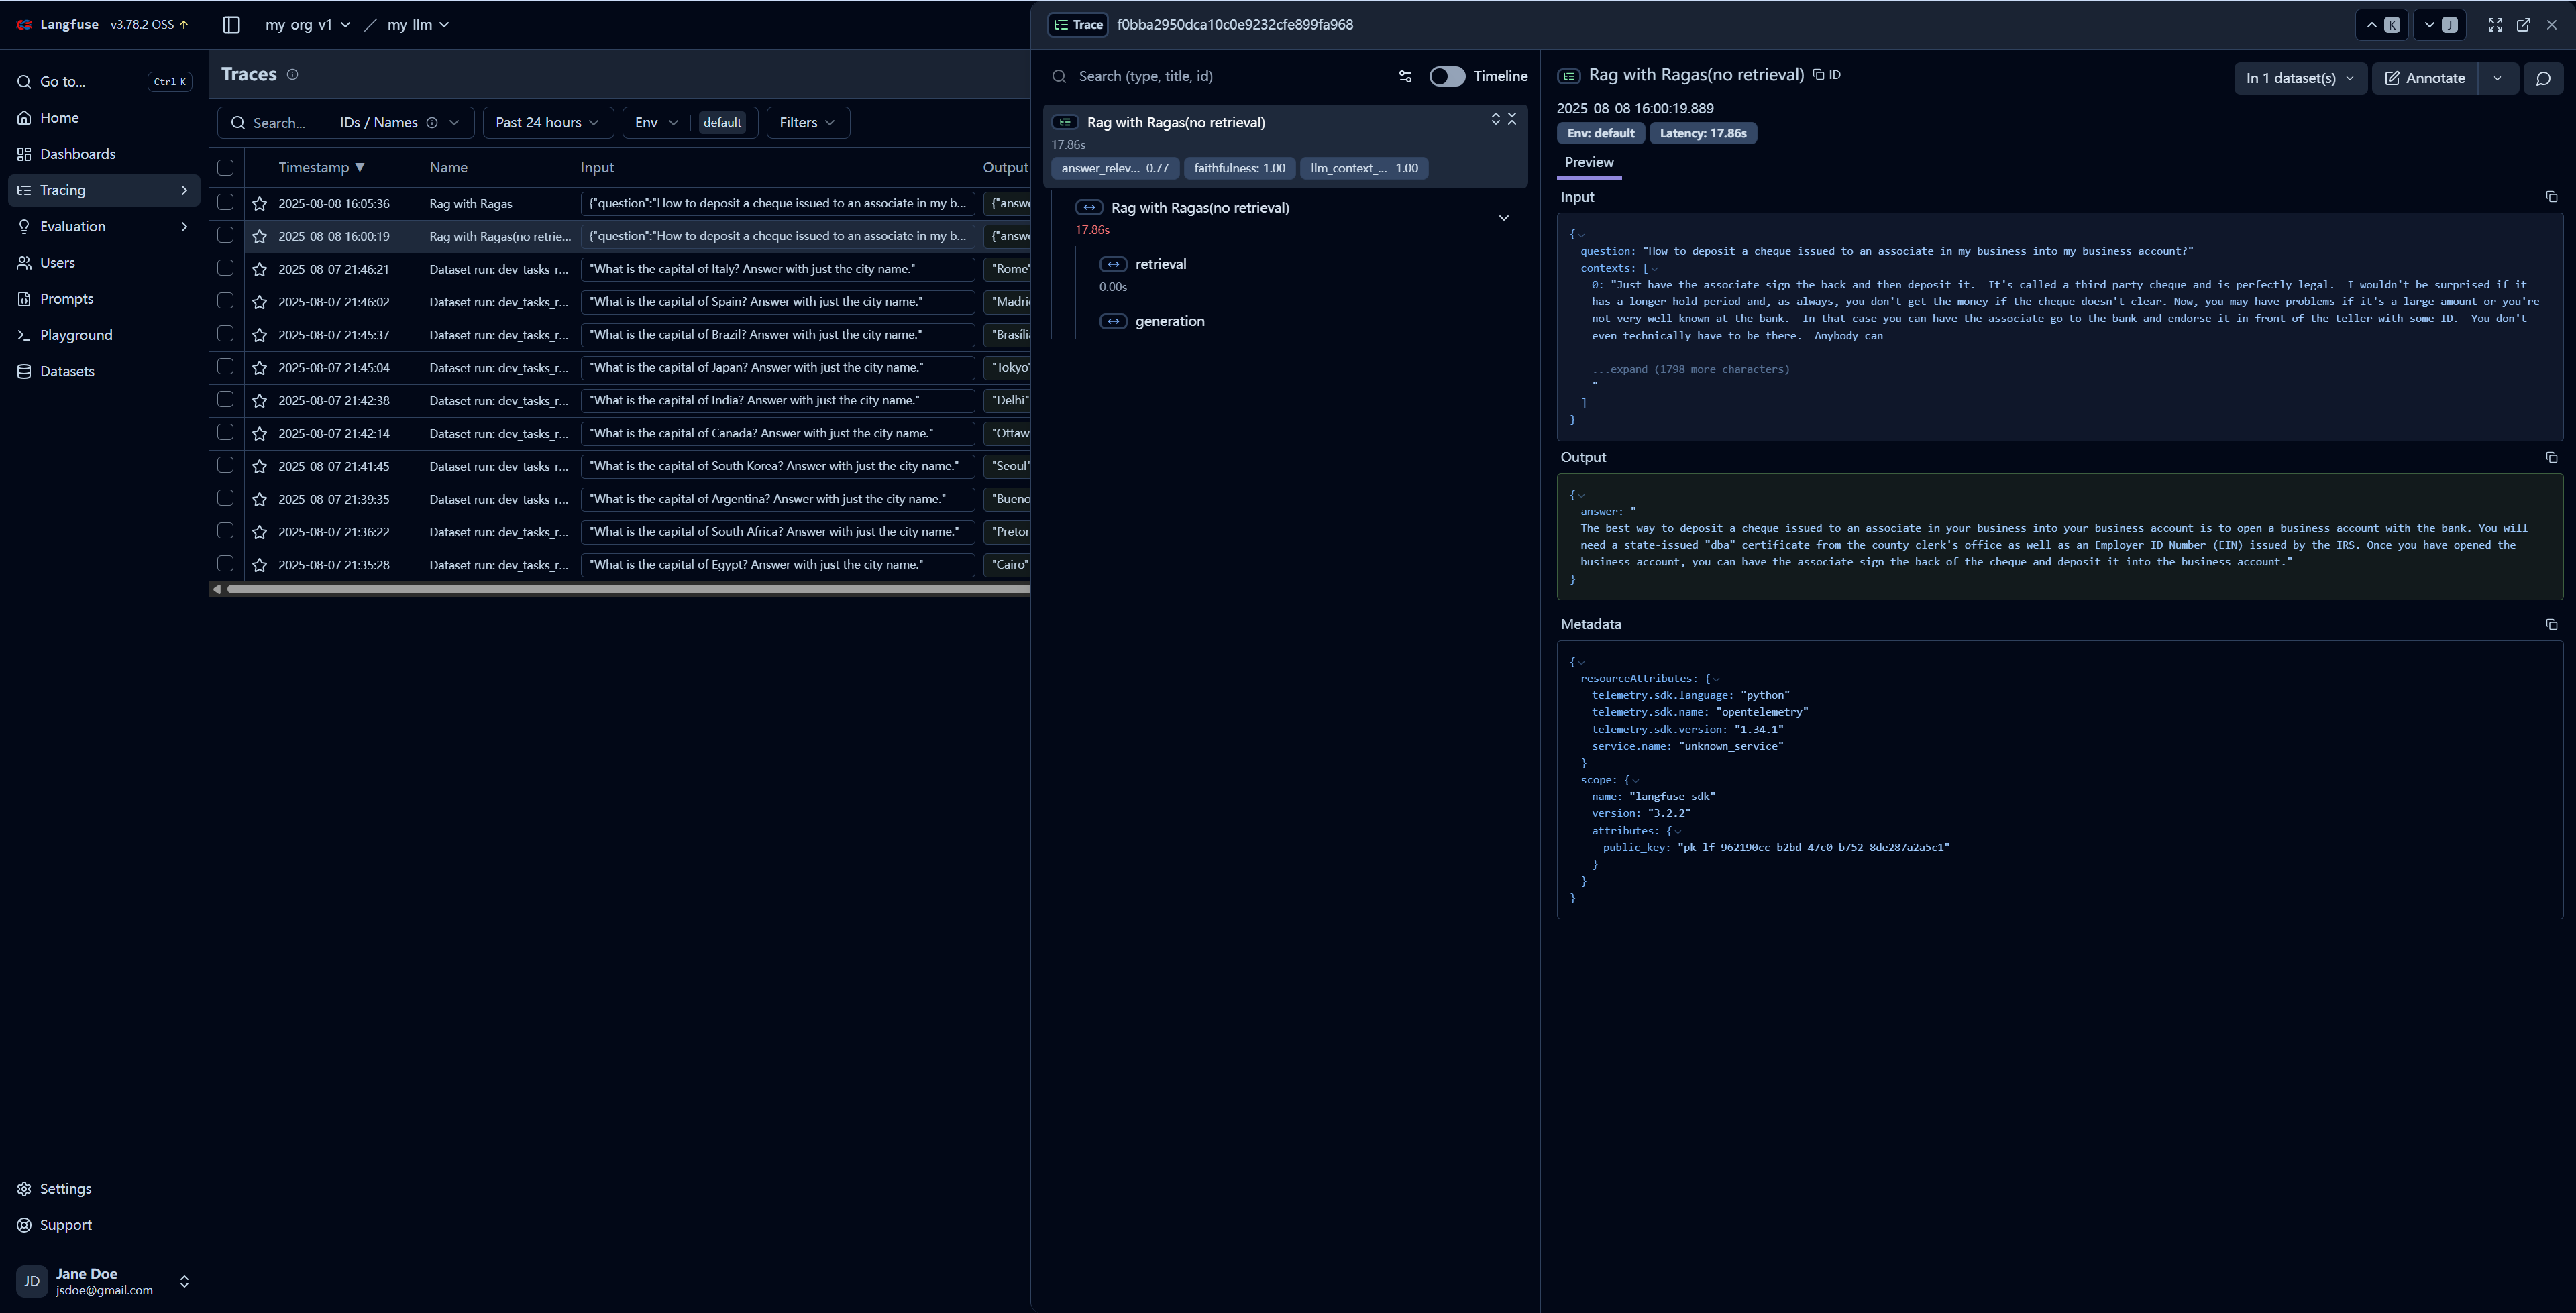

#### Use  RAG(FAISS) + RAGAS

In [ ]:

from langchain.schema import Document
from langchain.vectorstores import FAISS

#  Simulated Knowledge Base
docs = [
    Document(page_content="To deposit a cheque issued to an associate into your business account, ensure the cheque is properly endorsed and provide documentation proving the business relationship to your bank."),
    Document(page_content="Business accounts allow you to manage company finances, deposit cheques, and make payments. Always keep records of all transactions for accounting purposes."),
    Document(page_content="When depositing third-party cheques, banks may require additional verification, such as authorization letters or proof of identity for the associate."),
    Document(page_content="For large deposits, contact your bank in advance to confirm the required documents and processing time."),
]

vectorstore = FAISS.from_documents(docs, emb)


# 查看所有原始文档内容
for idx in vectorstore.index_to_docstore_id.values():
    doc = vectorstore.docstore.search(idx)
    print(doc.page_content)

# 查看向量数量
print(len(vectorstore.index_to_docstore_id))

# 查看 FAISS 索引对象
print(vectorstore.index)



To deposit a cheque issued to an associate into your business account, ensure the cheque is properly endorsed and provide documentation proving the business relationship to your bank.
Business accounts allow you to manage company finances, deposit cheques, and make payments. Always keep records of all transactions for accounting purposes.
When depositing third-party cheques, banks may require additional verification, such as authorization letters or proof of identity for the associate.
For large deposits, contact your bank in advance to confirm the required documents and processing time.
4
<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x00000172EEB7C060> >


In [ ]:
# Retrieve similar document chunks
def get_similar_chunks(query, k=2):
    retriever = vectorstore.as_retriever(search_kwargs={"k": k})
    return retriever.get_relevant_documents(query)


question = row['question']

# retrieve the relevant chunks
chunks = get_similar_chunks(question)

print("chunks:", chunks)

chunks: [Document(id='5a0047aa-73b2-47ec-8ebd-7d34b5c83f29', metadata={}, page_content='To deposit a cheque issued to an associate into your business account, ensure the cheque is properly endorsed and provide documentation proving the business relationship to your bank.'), Document(id='1ee23205-79a7-41a1-b7c3-2fb36a43e6a4', metadata={}, page_content='When depositing third-party cheques, banks may require additional verification, such as authorization letters or proof of identity for the associate.')]


In [75]:
# Get LLM response
def get_response_llm(question, chunks):
    chunks_text = "\n".join([doc.page_content for doc in chunks])
    prompt = f"Answer the following question based on the provided context.\nContext:\n{chunks_text}\nQuestion: {question}"
    return llm.predict(prompt)


# use llm to generate a answer with the trunks
answer = get_response_llm(question, chunks)

print("answer:", answer)

answer: 
Based on the provided context, here's how to deposit a cheque issued to an associate in your business account:

1.  **Endorse the Cheque:** Ensure the cheque is properly endorsed (signed or stamped as required by the bank).
2.  **Provide Documentation:** Give your bank documentation proving the business relationship between you and the associate.
3.  **Be Prepared for Additional Verification:** Be aware that banks may require extra steps, such as authorization letters or proof of identity for the associate, especially when depositing third-party cheques.


In [86]:

from langchain.schema import Document
from langchain.vectorstores import FAISS

#  Simulated Knowledge Base
docs = [
    Document(page_content="To deposit a cheque issued to an associate into your business account, ensure the cheque is properly endorsed and provide documentation proving the business relationship to your bank."),
    Document(page_content="Business accounts allow you to manage company finances, deposit cheques, and make payments. Always keep records of all transactions for accounting purposes."),
    Document(page_content="When depositing third-party cheques, banks may require additional verification, such as authorization letters or proof of identity for the associate."),
    Document(page_content="For large deposits, contact your bank in advance to confirm the required documents and processing time."),
]

vectorstore = FAISS.from_documents(docs, emb)

# Retrieve similar document chunks
def get_similar_chunks(query, k=2):
    retriever = vectorstore.as_retriever(search_kwargs={"k": k})
    return retriever.get_relevant_documents(query)

# Get LLM response
def get_response_llm(question, chunks):
    chunks_text = "\n".join([doc.page_content for doc in chunks])
    prompt = f"Answer the following question based on the provided context.\nContext:\n{chunks_text}\nQuestion: {question}"
    return llm.predict(prompt)


question = row['question']
contexts = row['contexts']
answer = row['answer']

with langfuse.start_as_current_span(name="Rag with Ragas") as trace:
    # Store trace_id for later use
    trace_id = trace.trace_id

    # retrieve the relevant chunks
    chunks = get_similar_chunks(question)

    # pass it as span
    with trace.start_as_current_span(
        name="retrieval",
        input={"question": question},
        output={"contexts": contexts}
    ):
        trace.update(input={"question": question, "contexts": contexts})


    # use llm to generate a answer with the trunks
    answer = get_response_llm(question, chunks)

    with trace.start_as_current_span(
        name="generation",
        input={"question": question, "contexts": contexts},
        output={"answer": answer}
    ):
        trace.update(output={"answer": answer})

    # compute scores for the questions, context, answer tuple
    ragas_scores = await score_with_ragas(question, contexts, answer)


print("RAGAS Scores:", ragas_scores)
ragas_scores

calculating faithfulness
calculating answer_relevancy
calculating llm_context_precision_without_reference
RAGAS Scores: {'faithfulness': 0.4, 'answer_relevancy': np.float64(0.8528518310858985), 'llm_context_precision_without_reference': 0.9999999999}


{'faithfulness': 0.4,
 'answer_relevancy': np.float64(0.8528518310858985),
 'llm_context_precision_without_reference': 0.9999999999}

Once the scores are computed you can add them to the trace in Langfuse:

In [87]:
# send the scores
# Use the trace_id stored from the previous cell
for m in metrics:
    langfuse.create_score(
        name=m.name, 
        value=ragas_scores[m.name], 
        trace_id=trace_id
    )

[trace url](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces?peek=9e3266db32a9ad80d99561b1963655f4&timestamp=2025-08-08T08%3A05%3A36.778Z)

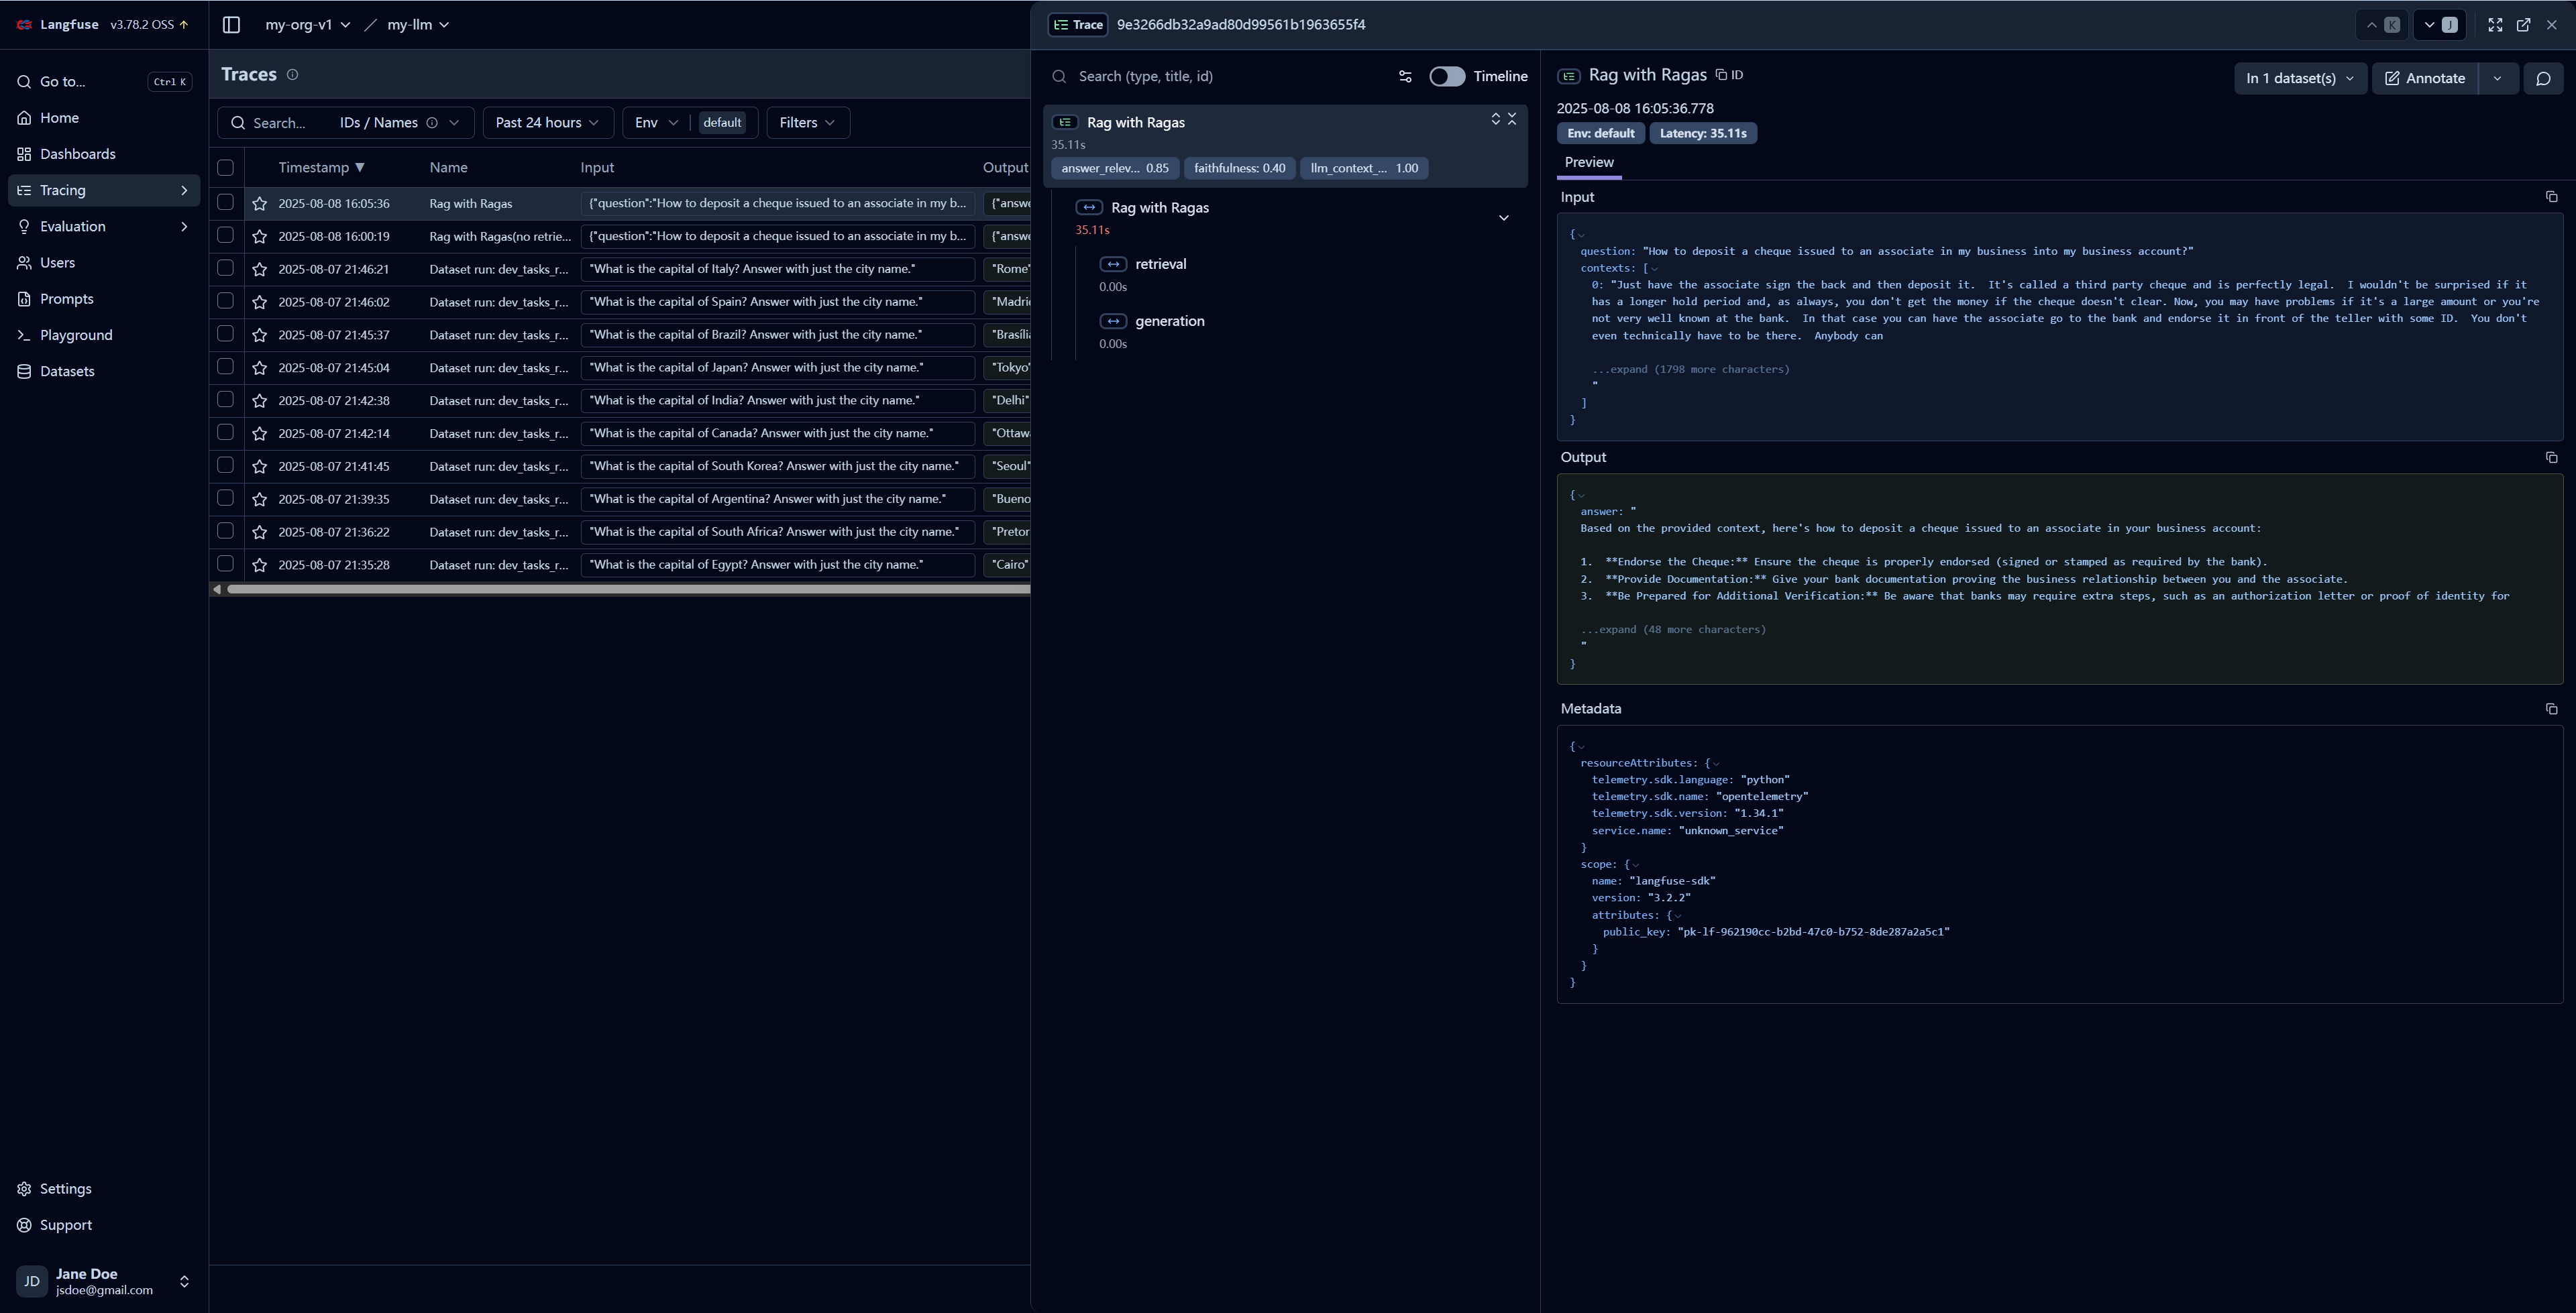



### [Run Langchain Evaluations on data in Langfuse](https://langfuse.com/guides/cookbook/evaluation_with_langchain)

This cookbook shows how model-based evaluations can be used to automate the evaluation of production completions in Langfuse. This example uses Langchain and is adaptable to other libraries. Which library is the best to use depends heavily on the use case.

This cookbook follows three steps:

1. Fetch production generations stored in Langfuse
2. Evaluate these generations using Langchain
3. Ingest results back into Langfuse as scores
